In [1]:
import numpy as np
import cv2
import sys
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,15.0)
objectnessThreshold = 0.5 # Objectness threshold
matplotlib.rcParams['image.cmap'] = 'gray'

## <font style="color:rgb(50,120,229)">Step 1 : Initialize the parameters</font>
The YOLOv3 algorithm generates bounding boxes as the predicted detection outputs. Every predicted box is associated with a confidence score. In the first stage, all the boxes below the confidence threshold parameter are ignored for further processing.

The rest of the boxes undergo non-maximum suppression which removes redundant overlapping bounding boxes. **Non-maximum suppression** is controlled by a parameter **nmsThreshold**. You can try to change these values and see how the number of output predicted boxes changes.

Next, the default values for the input width (**inpWidth**) and height (**inpHeight**) for the network’s input image are set. We set each of them to 416, so that we can compare our runs to the Darknet’s C code given by YOLOv3’s authors. You can also change both of them to 320 to get faster results or to 608 to get more accurate results.


In [3]:
# Initialize the parameters
confThreshold = 0.1       # Confidence threshold
nmsThreshold = 0.4        # Non-maximum suppression threshold
inpWidth = 416            # Width of network's input image
inpHeight = 416           # Height of network's input image

In [6]:

# Load names of classes
classesFile = "data/coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "cfg/yolov3.cfg"
modelWeights = "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

In [7]:
net

<dnn_Net 000001B346F1B830>

The **forward** function in OpenCV’s Net class needs the ending layer till which it should run in the network. Since we want to run through the whole network, we need to identify the last layer of the network. We do that by using the function **getUnconnectedOutLayers()** that gives the names of the unconnected output layers, which are essentially the last layers of the network. Then we run the forward pass of the network to get output from the output layers, as in the previous code snippet (**net.forward(getOutputsNames(net))**).


In [8]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [9]:
getOutputsNames(net)

['yolo_82', 'yolo_94', 'yolo_106']

In [10]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

The network outputs bounding boxes are each represented by a vector of number of classes + 5 elements.

The first 4 elements represent the **center_x**, **center_y**, **width** and **height**. The fifth element represents the confidence that the bounding box encloses an object.

The rest of the elements are the confidence associated with each class (i.e. object type). The box is assigned to the class corresponding to the highest score for the box.

The highest score for a box is also called its **confidence**. If the confidence of a box is less than the given threshold, the bounding box is dropped and not considered for further processing.

The boxes with their confidence equal to or greater than the confidence threshold are then subjected to Non Maximum Suppression. This would reduce the number of overlapping boxes.


In [11]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold :
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

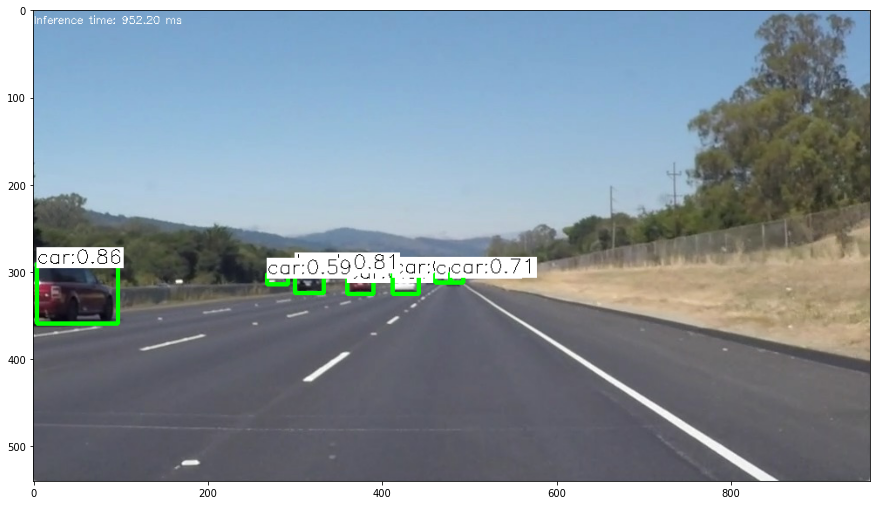

Inference time: 952.20 ms


In [12]:
DATA_PATH = 'CarND-LaneLines-P1-master/test_images/'
# Process inputs
imagePath = DATA_PATH + "solidWhiteRight.jpg"
frame = cv2.imread(imagePath)


# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))
#outs = net.forward()

# Remove the bounding boxes with low confidence
postprocess(frame, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255))

plt.imshow(frame[...,::-1])
plt.show()
print(label)

In [11]:
np.set_printoptions(threshold=sys.maxsize)
print(outs)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [37]:
video = cv2.VideoCapture('CarND-LaneLines-P1-master/test_videos/challenge.mp4')
while(video.isOpened()):
    
    _,frame = video.read()

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
    
    net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))
    #outs = net.forward()

    # Remove the bounding boxes with low confidence
    postprocess(frame, outs)

    # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
    cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255))

    cv2.imshow('test',frame[...,::-1])
#     plt.show()
#     print(label)
    key = cv2.waitKey(50)
    if key == ord('q'):
        break
video.release()
cv2.destroyAllWindows()
